In [1]:
# general imports

import warnings  # noqa
from pathlib import Path  # noqa

import matplotlib.pyplot as plt  # noqa
import numpy as np  # noqa
import pandas as pd  # noqa
import scipy as sp  # noqa
import seaborn as sns  # noqa

In [2]:
# sklearn imports

from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline

In [3]:
# magic functions
# Editor > Code Style > Formatter > Turn formatter on/off with markers in code comments

# @formatter:off
%matplotlib inline
# @formatter:on

In [4]:
# plot config

sns.set_theme(context='notebook', style='darkgrid')
plt.rcParams['figure.figsize'] = (8, 4)

In [5]:
# constants

DATA_DIR = Path('../data/')

# Задание

Очистка данных и обучение моделей.
Датасет: https://www.kaggle.com/akshayksingh/kidney-disease-dataset

# Общие этапы

- Загрузить датасет в Python.
- Описать набор данных и решаемую задачу.
- Выделить целевую переменную и факторные переменные.
- Удалить ненужные данные, проанализировать отсутствующие значения.
- Прокомментировать количественные параметры датасета.
- Разбить выборку на обучающую и тестовую.

In [6]:
df: pd.DataFrame = pd.read_csv(DATA_DIR / 'kidney_disease.csv')
df = df.drop(columns=['id'])
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35,7300,4.6,no,no,no,good,no,no,ckd


Задача - задача **классификации** - на основании признаков (сахар, эритроциты, ...) определить есть ли у пациента хроническая болезнь почек (cdk) или нет.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              353 non-null    float64
 3   al              354 non-null    float64
 4   su              351 non-null    float64
 5   rbc             248 non-null    object 
 6   pc              335 non-null    object 
 7   pcc             396 non-null    object 
 8   ba              396 non-null    object 
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             330 non-null    object 
 16  wc              295 non-null    object 
 17  rc              270 non-null    obj

Датасет состоит из 25 колонок - 24 признака и 1 целевая переменная - `classification` (26-ая колонка `id` была удалена при загрузке данных, т.к. не несет никакой полезной информации для решения задачи) - и 400 строк.

В датасете представлены как числовые, так и нечисловые категориальные признаки. Пресутсвуют пропуски.

Можно заметить неожиданный тип данных `object` для признаков `pcv`, `wc`, `rc`,
хотя в предварительном просмотре мы видели числовые значения.

_Я заметил позже, но напишем об этом тут, чтобы не нарушать порядок повествования._

Рассмотрим эти колонки подробнее:

In [8]:
def apply(s: pd.Series):
    convert = [pd.to_numeric(x, errors='ignore') for x in s]
    # не совсем верно использовать isinstance(x, str), но в данных задачах - и так сойдет
    numeric = [x for x in convert if not isinstance(x, str)]
    strings = [x for x in convert if isinstance(x, str)]
    return f'n: {len(s)}, num: {len(numeric)}, str: {len(strings)}, {set(strings)}'


problem_cols = ['pcv', 'wc', 'rc']
df[problem_cols].apply(apply)

pcv    n: 400, num: 399, str: 1, {'\t?'}
wc     n: 400, num: 399, str: 1, {'\t?'}
rc     n: 400, num: 399, str: 1, {'\t?'}
dtype: object

Аномальное значение `\t?` (возможны еще какие-то аномальные строки по типу `\t44`, с которыми `pd.to_numeric` успешно справился)
не позволило pandas при считывании верно определить тип данных этих колонок.

Приведем эти колонки к числовым типам, а аномальные значения временно заменим на NaN:

In [9]:
df[problem_cols] = df[problem_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))
df[problem_cols].dtypes

pcv    float64
wc     float64
rc     float64
dtype: object

Описательная статистика для числовых признаков:

In [10]:
df.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


_Очень сложно работать с английскими сокращениями медицинских терминов (лейкоциты, эритроциты) без знаний в этой области,
поэтому сделаем допущение, что все числовые признаки - честные числовые непрерывные или дискретные данные._

Посмотрим на шкалы категориальных признаков:

In [11]:
categorical_cols = df.columns[df.dtypes == object]

df[categorical_cols].apply(lambda s: s.unique())

rbc                         [nan, normal, abnormal]
pc                          [normal, abnormal, nan]
pcc                      [notpresent, present, nan]
ba                       [notpresent, present, nan]
htn                                  [yes, no, nan]
dm                [yes, no,  yes, \tno, \tyes, nan]
cad                            [no, yes, \tno, nan]
appet                             [good, poor, nan]
pe                                   [no, yes, nan]
ane                                  [no, yes, nan]
classification                 [ckd, ckd\t, notckd]
dtype: object

Видно, что некоторые значения категориальных данных "болеют пробельными символами",
из-за этого шкалы ошибочно расширяются.

Удалим лишние пробельные символы:

In [12]:
df[categorical_cols] = df[categorical_cols].apply(lambda s: s.str.strip())

df[categorical_cols].apply(lambda s: s.unique())

rbc                  [nan, normal, abnormal]
pc                   [normal, abnormal, nan]
pcc               [notpresent, present, nan]
ba                [notpresent, present, nan]
htn                           [yes, no, nan]
dm                            [yes, no, nan]
cad                           [no, yes, nan]
appet                      [good, poor, nan]
pe                            [no, yes, nan]
ane                           [no, yes, nan]
classification                 [ckd, notckd]
dtype: object

Видно, что все категориальные признаки являются **номинальными** и даже бинарными (если не рассматривать пропуски как 3-ий тип значений):
- `normal - abnormal`
- `present - notpresent`
- `yes - no`
- `good - poor`

Целевая переменная принимает значения `ckd` - есть хроническая болезнь почек, `notckd` - нет.

Последнее, проверим распределение целевой переменной:

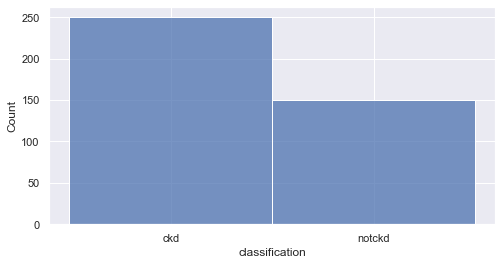

In [13]:
sns.histplot(x=df['classification']);

Явной несбалансированности классов невыявлено.

_Работу с пропусками, удаление лишних признаков и разбиение на обучающую и тестовую выборки проведем в следующем разделе, т.к. это является частью основного задания_

# Очистка данных и обучение моделей

Попробуем выявить ненужные признаки.
Делать предположения о важности имеющихся признаков невозможно (я не знаю) _(и не рекомендуется)_.

Попробуем выявить мультиколлинеарные признаки, проанализировав матрицу взаимных корреляций:

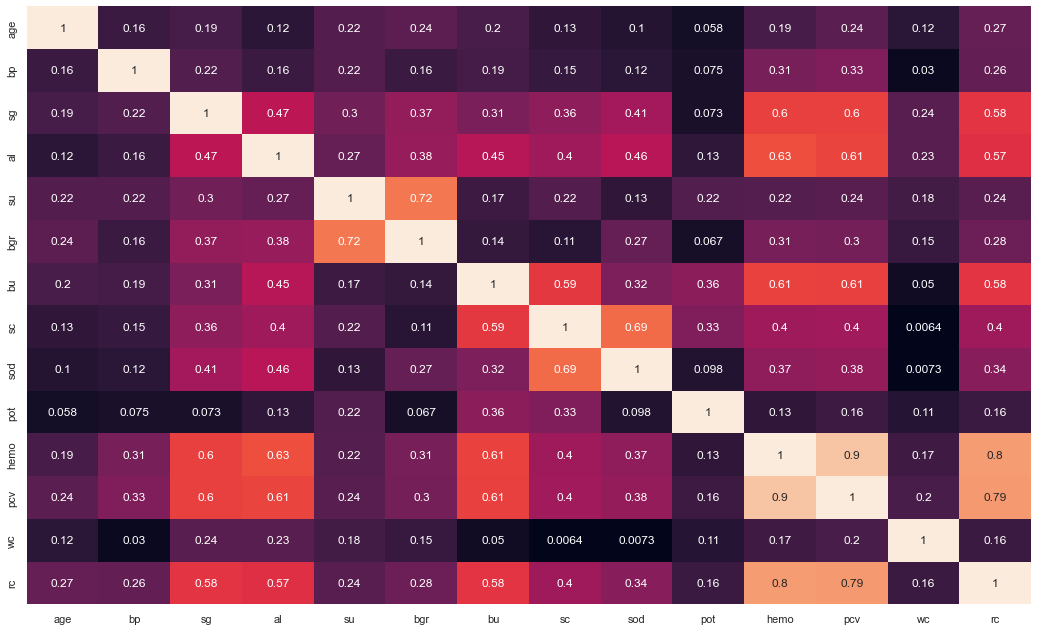

In [14]:
corr_abs = df[df.columns[:-1]].corr().abs()

_, ax = plt.subplots(figsize=(18, 11))
sns.heatmap(corr_abs, ax=ax, cbar=False, annot=True);

In [15]:
threshold = 0.9
cnt = pd.notna(corr_abs[corr_abs > threshold]).sum()
cnt[cnt > 1]  # одно значение == 1 - self-корреляция

Series([], dtype: int64)

Проблема мультиколлинеарности незамеченна. Все признаки оставим в наборе и будем считать их значимыми.

Прежде чем что-то делать с пропусками, посмотрим на их количество в колонках:

In [16]:
cnt = df.isna().sum()
cnt[cnt > 0].sort_values(ascending=False)

rbc      152
rc       131
wc       106
pot       88
sod       87
pcv       71
pc        65
hemo      52
su        49
sg        47
al        46
bgr       44
bu        19
sc        17
bp        12
age        9
ba         4
pcc        4
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
dtype: int64

В некоторых колонках пропусков очень много, поэтому просто удалить пропуски нельзя. Поэтому попробуем стратегию:
1. удалим признаки `rbc`, `rc` и `wc` - очень много пропусков
2. пропуски в категориальных и дискретных восстановим модой
3. пропуски в `pot`, `sod`, `pcv`, `hemo` заменим средним - много пропусков
4. удалим остальные пропуски

In [17]:
# 1
drop = ['rbc', 'rc', 'wc']
tidy = df.drop(columns=drop)

In [18]:
# 2
mode_cols = list({'age', *tidy.columns[tidy.dtypes == object]} - {'classification'})
mode = tidy[mode_cols].mode().squeeze(axis=0)
tidy[mode_cols] = tidy[mode_cols].fillna(mode)
mode

appet          good
ane              no
pcc      notpresent
dm               no
cad              no
age            60.0
pe               no
htn              no
pc           normal
ba       notpresent
Name: 0, dtype: object

In [19]:
# 3
mean_cols = ['pot', 'sod', 'pcv', 'hemo']
mean = tidy[mean_cols].mean()
tidy[mean_cols] = tidy[mean_cols].fillna(mean)
mean

pot       4.627244
sod     137.528754
pcv      38.884498
hemo     12.526437
dtype: float64

In [20]:
# 4
tidy = tidy.dropna()
print(f'Было: {len(df)}\n'
      f'Осталось: {len(tidy)}\n'
      f'Удалось сохранить: {len(tidy) / len(df) * 100:g}%')

Было: 400
Осталось: 300
Удалось сохранить: 75%


Преобразуем категориальные признаки в числовые:

In [21]:
# хотя для целевой переменной документация sklearn рекомендует применять LabelEncoder,
# в данном случае проще и очевиднее сделать так:
categorical_cols = tidy.columns[tidy.dtypes == object]

enc = OrdinalEncoder()
enc.fit(tidy[categorical_cols])
enc.categories_

[array(['abnormal', 'normal'], dtype=object),
 array(['notpresent', 'present'], dtype=object),
 array(['notpresent', 'present'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['good', 'poor'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['ckd', 'notckd'], dtype=object)]

In [22]:
tidy[categorical_cols] = enc.transform(tidy[categorical_cols])
tidy[categorical_cols].head()

,pc,pcc,ba,htn,dm,cad,appet,pe,ane,classification
0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


Выделим целевую переменную и разделим выборку на обучающую и тестовую:

In [23]:
X, y = tidy[tidy.columns[:-1]], tidy[tidy.columns[-1]]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Рассмотрим наиболее популярные классификаторы. Оценивать будем с помощью кросс-валидации по метрикам:
- accuracy
- precision
- recall
- f1-score - приоритет!
- fit time
- score time

In [25]:
estimator = Pipeline([
    ('clf', LogisticRegression())
])

In [26]:
estimate_param_grid = [{
    'clf': [
        LogisticRegression(random_state=0),
        KNeighborsClassifier(),
        SVC(random_state=0),
        LinearSVC(random_state=0),
        PassiveAggressiveClassifier(random_state=0),
        RandomForestClassifier(random_state=0),
        ExtraTreesClassifier(random_state=0),
        RidgeClassifier(random_state=0),
        MLPClassifier(random_state=0),
        SGDClassifier(loss='hinge', random_state=0),  # LinearSVC
        SGDClassifier(loss='log_loss', random_state=0),  # LogisticRegression
        SGDClassifier(loss='modified_huber', random_state=0),  # толерантность к выбросам
        SGDClassifier(loss='squared_hinge', random_state=0),  # SVC с квадратичным штрафом
        SGDClassifier(loss='perceptron', random_state=0),  # MLP
    ]
}]

scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

grid_search = GridSearchCV(
    estimator,
    estimate_param_grid,
    scoring=scoring,
    refit='f1_weighted',
    cv=3,
    verbose=4,
    n_jobs=4,
)

In [27]:
if __name__ == '__main__':
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=ConvergenceWarning)
        warnings.simplefilter('ignore', category=UndefinedMetricWarning)
        grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


In [28]:
keys = [
    'params',
    'mean_test_f1_weighted',
    'mean_fit_time',
    'mean_score_time',
    'mean_test_accuracy',
    'mean_test_precision_weighted',
    'mean_test_recall_weighted',
]

report = pd.DataFrame(grid_search.cv_results_)[keys]
report['params'] = report['params'].apply(lambda x: str(x['clf']).replace('random_state=0', ''))
report = report.rename(columns=lambda x: x.replace('_test', '').replace('_weighted', '').replace('mean_', ''))

Сравнение моделей:

In [29]:
report.sort_values('f1', ascending=False)

,params,f1,fit_time,score_time,accuracy,precision,recall
6,ExtraTreesClassifier(),0.995838,0.085710,0.009654,0.995833,0.995946,0.995833
5,RandomForestClassifier(),0.991653,0.122933,0.014351,0.991667,0.991850,0.991667
0,LogisticRegression(),0.979213,0.033739,0.005334,0.979167,0.980946,0.979167
7,RidgeClassifier(),0.945987,0.003508,0.002369,0.945833,0.952800,0.945833
8,MLPClassifier(),0.908259,0.086794,0.004003,0.908333,0.911449,0.908333
9,SGDClassifier(),0.898839,0.004072,0.004333,0.900000,0.912643,0.900000
13,"SGDClassifier(loss='perceptron', )",0.898839,0.001680,0.003346,0.900000,0.912643,0.900000
12,"SGDClassifier(loss='squared_hinge', )",0.881724,0.003350,0.003350,0.883333,0.891477,0.883333
10,"SGDClassifier(loss='log_loss', )",0.879996,0.003667,0.004369,0.883333,0.894101,0.883333
1,KNeighborsClassifier(),0.857754,0.001513,0.113034,0.858333,0.883177,0.858333


Без настройки гиперпараметров с задачей лучше всего справился `ExtraTreesClassifier`.

Посмотрим на результат на тестовой выборке:

In [30]:
# @formatter:off

In [31]:
%%time

clf = ExtraTreesClassifier(random_state=0)
_ = clf.fit(X_train, y_train)

CPU times: total: 78.1 ms
Wall time: 73.6 ms


In [32]:
%%time

y_pred = clf.predict(X_test)
# @formatter:on

CPU times: total: 15.6 ms
Wall time: 9.78 ms


In [33]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        31
         1.0       1.00      1.00      1.00        29

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



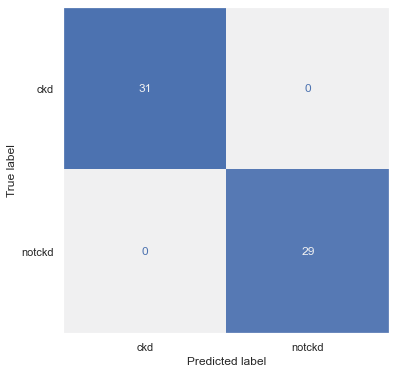

In [34]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=enc.categories_[-1],
    colorbar=False,
    cmap=sns.color_palette('light:b', as_cmap=True)
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(6, 6)

**Вывод:** даже с не очень аккуратным избавлением от пропусков получилось выбрать хорошую модель - `ExtraTreesClassifier` - ансамбль 100 чрезвычайно-рандомизированных деревьев.